In [1]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
!git config --global user.name "nomorebye"
!git config --global user.email "songirib@gmail.com"
!git init  # 로컬 Git 저장소 초기화
!git remote add origin https://github.com/YourUsername/YourRepositoryName.git  # 원격 저장소 추가


### 1. 패키지 설치 및 불러오기

In [ ]:
# 패키지 설치: yfinance, Riskfolio-Lib
!pip install yfinance --quiet
!pip install riskfolio-lib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 6.8 MB/s eta 0:00:00


In [ ]:
# 패키지 임포트: numpy, pandas, matplotlib, seaborn, scipy, yfinance, sklearn, riskfolio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn import covariance
from sklearn.covariance import ledoit_wolf
from scipy.cluster.hierarchy import linkage, dendrogram
import riskfolio as rp


#### 참고자료
- LedoitWolf: https://www.quantrocket.com/code/?repo=quant-finance-lectures&path=%2Fcodeload%2Fquant-finance-lectures%2Fquant_finance_lectures%2FLecture26-Estimating-Covariance-Matrices.ipynb.html
- Riskfolio-Lib: https://riskfolio-lib.readthedocs.io/en/latest/


### 2. ETF 데이터 수집 및 수익률 데이터 생성

- 티커 리스트

['SPY', 'FEZ', 'EWJ', 'EEM', 'IEF', 'TLT', 'TIP', 'GLD', 'DBC', 'DBA', 'IYR']

- 가격 데이터 시작일: 2007년 5월 1일
- 가격 데이터 종료일: 2023년 10월 31일
- 주간 단위로 리샘플링 및 종가 기준으로 백테스팅 수행

In [ ]:
# ETF 가격 데이터 호출 함수
def get_etf_price_data():
    tickers = ['SPY', 'FEZ', 'EWJ', 'EEM', 'IEF', 'TLT', 'TIP', 'GLD', 'DBC', 'DBA', 'IYR']
    etf = yf.Tickers(tickers)
    data = etf.history(start='2007-05-01', end='2023-10-31', actions=False)
    data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
    data = data.droplevel(0, axis=1)
    data.ffill(inplace=True)
    df = data.resample('W').last()
    return df


In [ ]:
# 가격 데이터
df = get_etf_price_data()

# 주간 수익률 데이터
rets = pd.DataFrame(df.pct_change().dropna())
rets.replace([np.inf, -np.inf], np.nan, inplace=True)

rets = rets.clip(lower=-0.1, upper=0.1)


[*********************100%***********************]  11 of 11 completed


### 3. Shrinkage 방법론을 활용한 공분산 행렬 노이즈 제거

In [ ]:
# Shrinkage 방법을 적용한 공분산 행렬 생성 함수
def covMatShrinkage_lediot_wolf(rets):

    # from sklearn import covariance 모듈의 ledoit_wolf를 활용한 공분산 행렬 노이즈 제거
    lw_cov_matrix = ledoit_wolf(rets)

    # lw 공분산 행렬 반환
    return lw_cov_matrix

<Axes: xlabel='Ticker', ylabel='Ticker'>

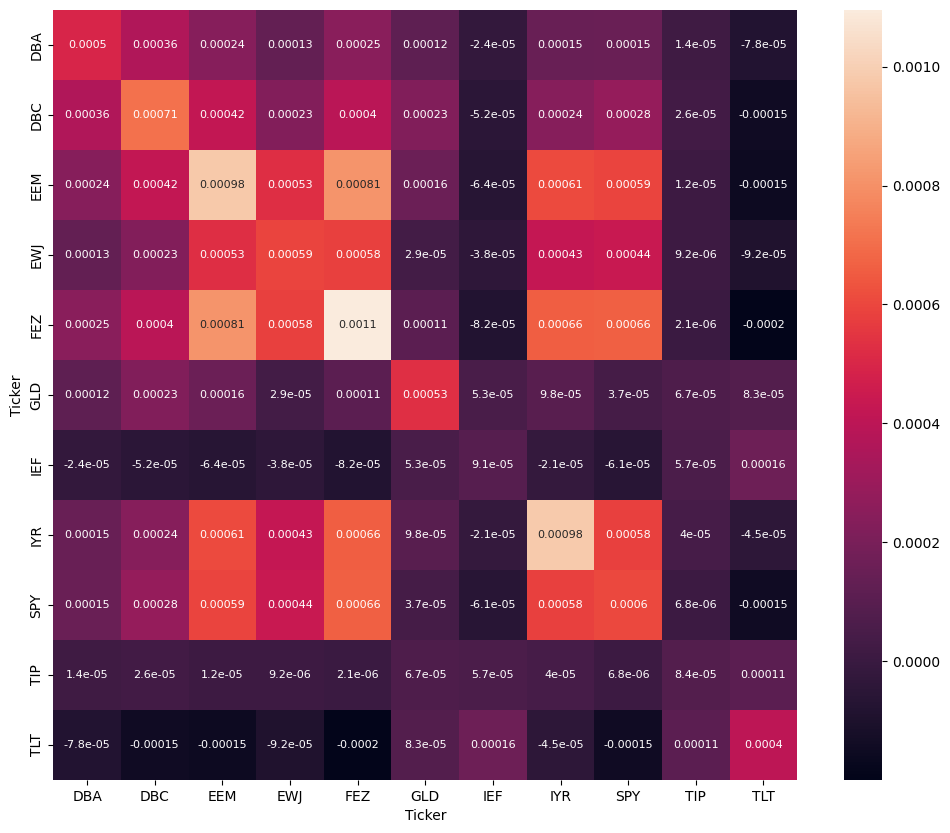

In [ ]:
# 수축된 공분산 행렬
shrinked_cov_mat = covMatShrinkage_lediot_wolf(rets)
shrinked_cov_mat = pd.DataFrame(shrinked_cov_mat[0], columns = df.columns, index=df.columns)
# 수축된 공분산 행렬 히트맵(sns.heatmap) 시각화 (annot=True, annot_kws={"size": 8})
plt.figure(figsize=(12,10))
sns.heatmap(shrinked_cov_mat, annot=True, annot_kws={'size':8}, xticklabels=rets.columns, yticklabels=rets.columns)

### 4. 계층적 리스크 패리티 포트폴리오

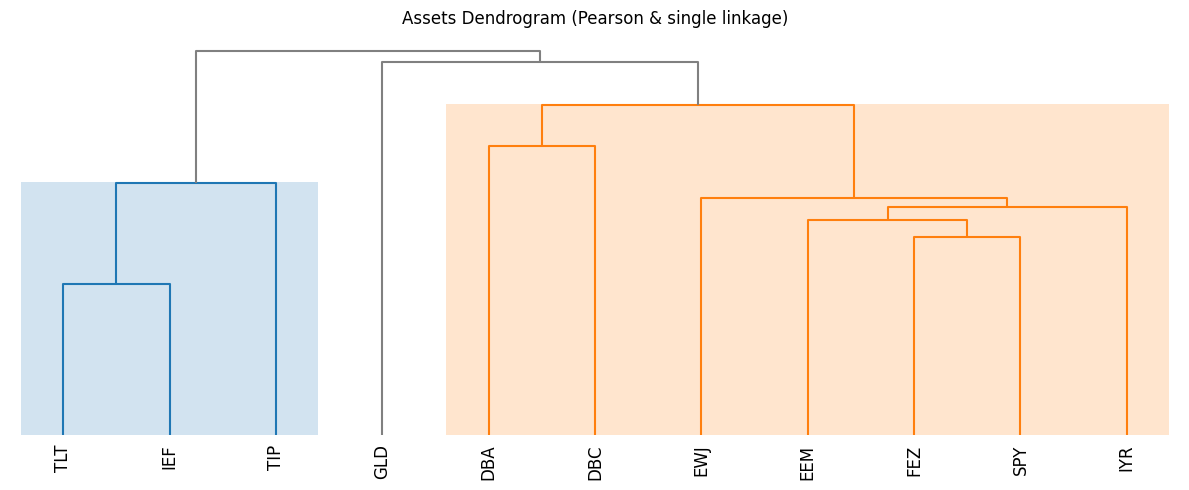

In [ ]:
# 덴드로그램 구현
ax = rp.plot_dendrogram(returns=rets,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)


In [ ]:
# HRP 객체 구현
port = rp.HCPortfolio(returns=rets)

model='HRP'
codependence = 'pearson'
rm = 'MV'
rf = 0
linkage = 'single'
max_k = 10
leaf_order = True

hrp_weights = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)
# HRP 가중치 계산
hrp_weights

,weights
DBA,0.053838
DBC,0.034068
EEM,0.014730
EWJ,0.024291
FEZ,0.019312
GLD,0.050322
IEF,0.284318
IYR,0.012403
SPY,0.020237
TIP,0.426113


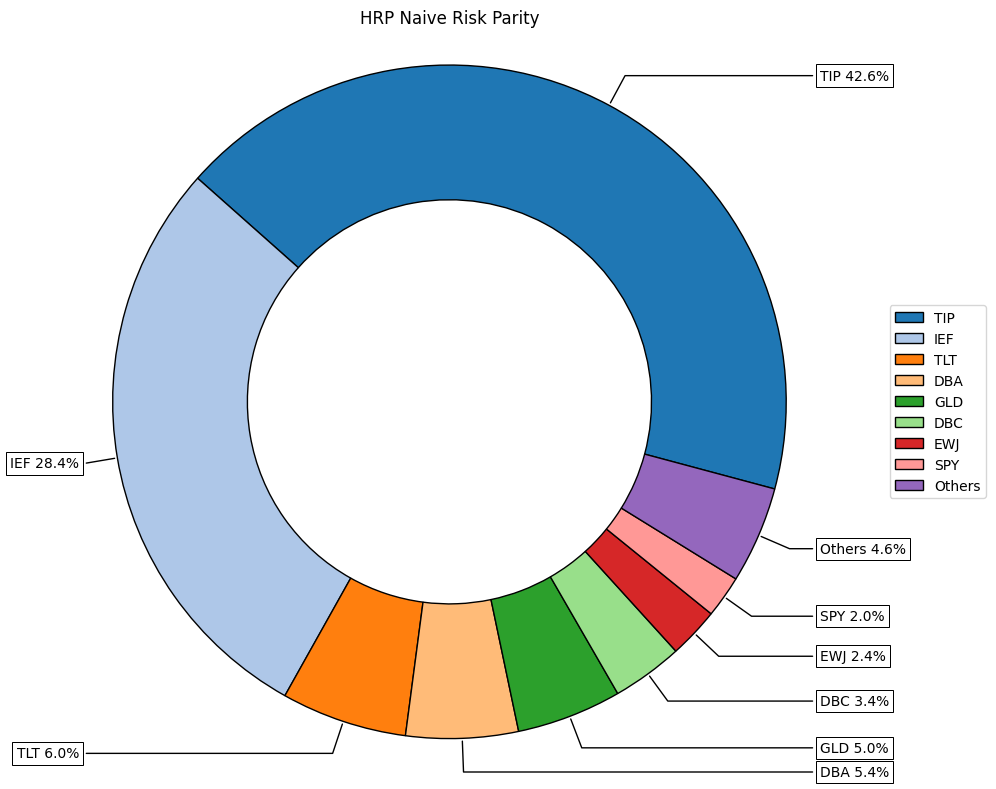

In [ ]:
# 가중치 파이 차트 시각화
ax = rp.plot_pie(w=hrp_weights,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

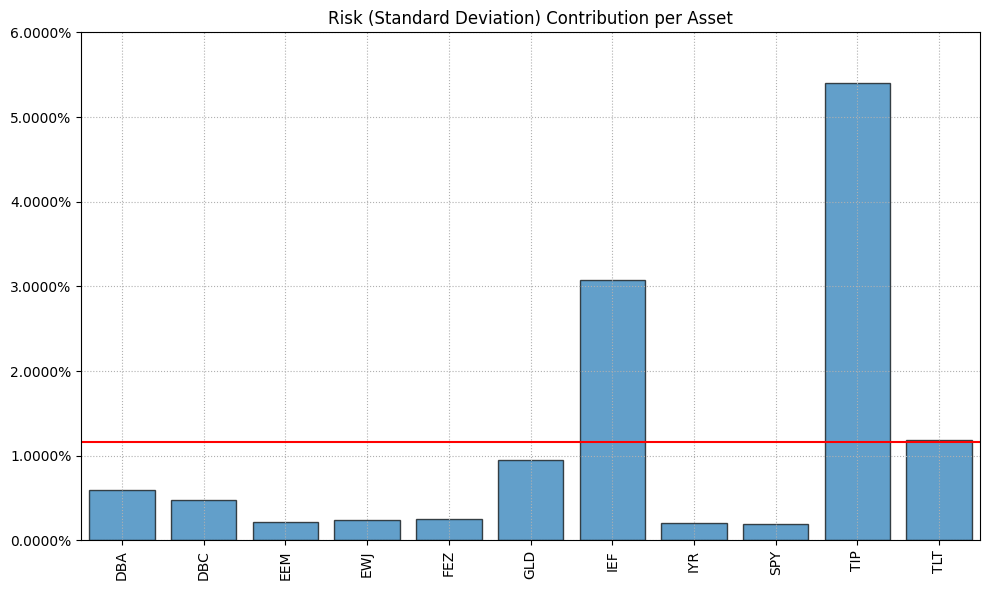

In [ ]:
# 자산별 위험 기여도 계산 및 시각화
mu = rets.mean()
cov = shrinked_cov_mat
returns = rets
ax = rp.plot_risk_con(w=hrp_weights,
                      cov=shrinked_cov_mat,
                      returns=rets,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

#### 5. SRP, HRP 포트폴리오 백테스팅 엔진 클래스 구현

In [ ]:
# 포트폴리오 백테스팅 엔진 클래스
class PortOptimPy:

    # 초기화 함수
    def __init__(self, price, param=52):
        # 연율화 패러미터
        self.param = param

        # 주간 수익률
        self.rets = price.pct_change().dropna()

    # 횡적 배분 모델 클래스
    class CrossSectional:

        def __init__(self, returns):
            self.returns = returns

        # 축소 리스크 패리티 함수 (srp)
        def srp(self):
            # 축소된 공분산 행렬 함수
            def shrinkage_covariance(returns):
                cov_matrix = returns.cov()
                cov_matrix, shrinkage = ledoit_wolf(returns)
                return cov_matrix

            # 동등 위험 기여 함수
            def risk_contribution(weights, cov_matrix):
                portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
                return np.dot(weights.T, np.dot(cov_matrix, weights)) / portfolio_variance

            # 리스크 패리티 가중치 계산 수행
            def calculate_weights(cov_matrix):
                inv_vol = 1 / np.sqrt(np.diag(cov_matrix))
                weights = inv_vol / np.sum(inv_vol)
                return weights

            # 공분산 행렬 축소
            cov_matrix = shrinkage_covariance(returns)
            # 가중치 계산
            weights = calculate_weights(cov_matrix)
            # 계산된 가중치 반환
            return weights

        # 계층적 리스크 패리티 함수 (hrp)
        def hrp(self, returns, model='HRP', codependence='pearson', rm='MV', rf=0, linkage='single', max_k=10, leaf_order=True):
            # 포트폴리오 객체 생성
            port = rp.HCPortfolio(returns=returns)

            # 공분산 행렬과 상관계수 계산
            cov_matrix = returns.cov()
            cov_matrix, _ = ledoit_wolf(returns)
            corr_matrix = self.returns.corr(method=codependence)

            port.cov = cov_matrix
            port.corr = corr_matrix
            # 최적 포트폴리오 가중치 추정
            weights = port.optimization(
                model=model,
                codependence=codependence,
                rm=rm,
                rf=rf,linkage=linkage,
                max_k=max_k,
                leaf_order=leaf_order
                )
            # 계산된 가중치 반환
            return weights

    # 거래비용 함수
    def transaction_costs(self, previous_weights, current_weights, cost_rate=0.001):
        # 이전 기의 투자 가중치
        delta_weights = current_weights - previous_weights

        # 거래비용 데이터프레임
        transaction_cost = np.abs(delta_weights).sum() * cost_rate
        return transaction_cost

    # 백테스팅 실행 함수
    def run(self, model='srp'):
        # 빈 딕셔너리
        backtest_dict = {}

        # 주간 수익률 데이터프레임
        rets = self.rets

        # 횡적 배분 모델 클래스 생성
        cs_model = self.CrossSectional(rets)

        # 횡적 배분 모델 선택 및 실행 (for 문)
        if model == 'srp':
            weights = cs_model.srp()
        elif model == 'hrp':
            weights = cs_model.hrp(returns)
        else:
            raise ValueError("Model should be either 'srp' or 'hrp'")

        # 가중치의 형태 확인 및 변환
        if isinstance(weights, pd.DataFrame) or len(weights.shape) > 1:
            weights = weights.squeeze()

        # 가중치 초기화 및 할당 (처음부터 전체 기간에 대해 할당)
        cs_weights = pd.DataFrame(index=rets.index, columns=rets.columns)
        cs_weights.iloc[0] = weights
        cs_weights = cs_weights.ffill()

        # 횡적 배분 모델 자산 수익률
        cs_port_rets = (cs_weights * rets).sum(axis=1)

        # 거래비용 계산
        previous_weights = np.zeros(len(weights))
        transaction_cost = self.transaction_costs(previous_weights, weights)

        # 횡적 배분 모델 포트폴리오 수익률
        port_asset_rets = cs_weights * rets - transaction_cost

        # 최종 포트폴리오 투자 가중치
        # (종적 배분 모형을 사용하지 않으므로 횡적 배분 모델과 동일)
        port_weights = cs_weights


        # 최종 포트폴리오 자산별 수익률
        port_asset_rets = port_weights.shift() * rets - transaction_cost

        # 최종 포트폴리오 수익률
        port_rets = port_asset_rets.sum(axis=1)
        port_rets.index = pd.to_datetime(port_rets.index).strftime("%Y-%m-%d")

        return port_weights, port_asset_rets, port_rets

        # 결과를 딕셔너리에 저장
        results['weights'] = port_weights
        results['transaction_cost'] = transaction_cost
        results['portfolio_returns'] = port_rets

        return results



### 6. 백테스팅 엔진 실행 및 성과분석

In [ ]:
# 엔진 초기화 (입력: 주간 가격 데이터)
portfolio = PortOptimPy(price=rets)

# SRP 포트폴리오 백테스팅 실행
results_srp = portfolio.run(model='srp')

# HRP 포트폴리오 백테스팅 실행
results_hrp = portfolio.run(model='hrp')


In [ ]:
# SRP 포트폴리오 수익률 시리즈
srp_weights = results_srp[0]
srp_returns = rets.dot(srp_weights.T)
# HRP 포트폴리오 수익률 시리즈
hrp_weights = results_hrp[0]
hrp_returns = rets.dot(hrp_weights.T)

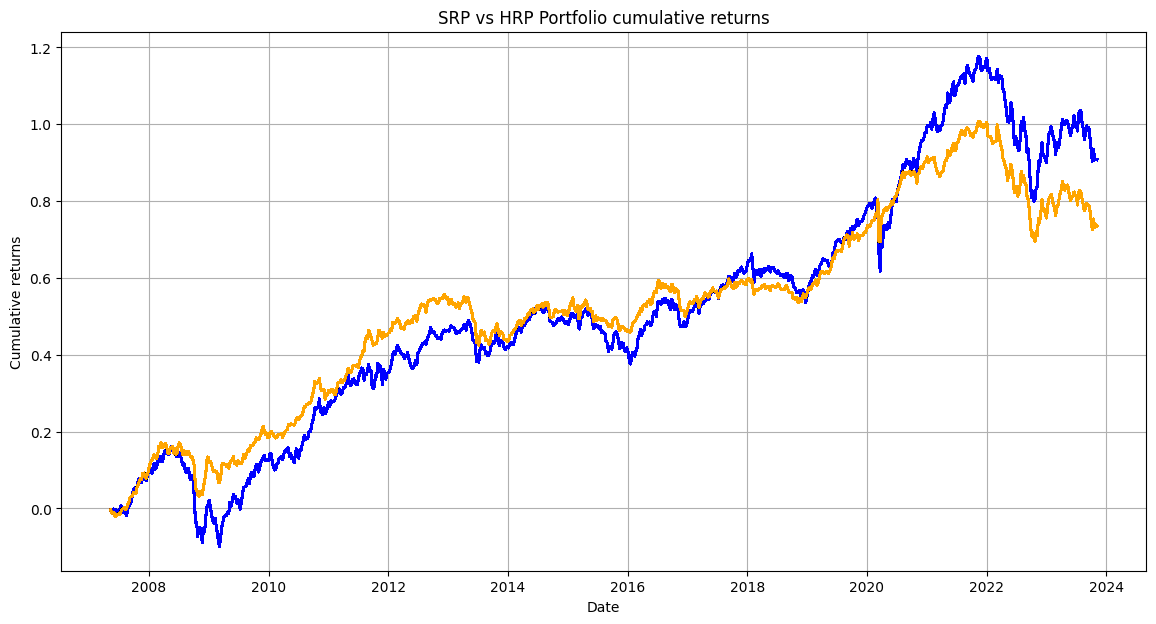

In [ ]:
# 특정 범위를 벗어나는 수익률을 이상치로 간주 및 제거
srp_returns_filtered = srp_returns[(srp_returns > srp_returns.quantile(0.01)) &
                                   (srp_returns < srp_returns.quantile(0.99))]

hrp_returns_filtered = hrp_returns[(hrp_returns > hrp_returns.quantile(0.01)) &
                                   (hrp_returns < hrp_returns.quantile(0.99))]

# 누적 수익률 다시 계산
srp_cumulative_returns = (1 + srp_returns).cumprod() - 1
hrp_cumulative_returns = (1 + hrp_returns).cumprod() - 1

# 그래프 설정
plt.figure(figsize=(14, 7))

# SRP 누적 수익률 그래프
plt.plot(srp_cumulative_returns, label='SRP Portfolio', color='blue')

# HRP 누적 수익률 그래프
plt.plot(hrp_cumulative_returns, label='HRP Portfolio', color='orange')

# 그래프 제목 및 레이블 설정
plt.title('SRP vs HRP Portfolio cumulative returns')
plt.xlabel('Date')
plt.ylabel('Cumulative returns')

# 그리드 및 시각적 개선
plt.grid(True)
plt.show()

In [ ]:
# 샤프 비율 계산 함수
def calculate_sharpe_ratio(portfolio_returns, risk_free_rate=0):
    # 포트폴리오의 평균 초과 수익률
    excess_returns = portfolio_returns.mean() - risk_free_rate

    # 포트폴리오 수익률의 표준편차
    return_std = portfolio_returns.std()

    # 샤프 비율 계산
    sharpe_ratio = excess_returns / return_std
    return sharpe_ratio

# SRP 포트폴리오 수익률 계산
srp_returns = srp_cumulative_returns

# HRP 포트폴리오 수익률 계산
hrp_returns = hrp_cumulative_returns

# SRP 샤프비율 계산
srp_sharpe_ratio = calculate_sharpe_ratio(srp_returns)

# HRP 사프비율 계산
hrp_sharpe_ratio = calculate_sharpe_ratio(hrp_returns)

# 두 포트폴리오의 샤프 비율 결과 출력

print(f"SRP 포트폴리오 샤프 비율: {float(srp_sharpe_ratio.mean()):.4f}")
print(f"HRP 포트폴리오 샤프 비율: {float(hrp_sharpe_ratio.mean()):.4f}")

SRP 포트폴리오 샤프 비율: 1.6283
HRP 포트폴리오 샤프 비율: 2.0459


Copyright 2023. 퀀트대디. All rights reserved.